## ML Based Model for Daytime Vertical ExB Drift in the Ethiopian Sector

### Daytime vertical E x B drift velocities inferred from ground-based magnetometer observations at low latitudes

### 1. Data Understanding

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.inspection import partial_dependence
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense 

import warnings
warnings.filterwarnings('ignore')

In [54]:
# df_fr = pd.read_csv('bng19980101dmin.min', delim_whitespace=True, skiprows=26, names=['DATE', 'TIME', 'DOY', 'AAEX', 'AAEY', 'AAEZ', 'AAEF_G']) 
# df_fr['TIMESTAMP'] = df_fr['DATE'] + ' ' + df_fr['TIME']
# df_fr['TIMESTAMP'] = pd.to_datetime(df_fr['TIMESTAMP'])
# df_fr['oHR'] = pd.to_datetime(df_fr['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S').dt.hour
# df_fr['oHR'] = df_fr['oHR'].astype(str).astype(int)
# df_fr['TIMESTAMP'] = df_fr['TIMESTAMP'].dt.tz_localize('utc').dt.tz_convert('Africa/Addis_Ababa')
# df_fr = df_fr.drop(columns='DATE')
# df_fr['DATE'] = pd.to_datetime(df_fr['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.date
# df_fr["YEAR"] = pd.DatetimeIndex(df_fr['DATE']).year
# df_fr['YEAR'] = df_fr['YEAR'].astype(str).astype(int)
# df_fr['HR'] = pd.to_datetime(df_fr['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.hour
# df_fr['HR'] = df_fr['HR'].astype(str).astype(int)
# df_fr = df_fr[['DATE', 'YEAR', 'DOY', 'oHR', 'HR', 'AAEX', 'AAEY']]
# # group and find average per hour
# def mean_value(col_data):
#     mean_data = pd.DataFrame()
#     if not col_data.empty:
#         mean_data = col_data.groupby(['DATE', 'HR']).mean()
#         mean_data.rename(columns={col: 'ha_' + col for col in mean_data.columns}, inplace=True)
#     return mean_data

# df_fr = mean_value(df_fr)
# df_fr = df_fr.reset_index(drop=False)
# df_fr['H'] = np.sqrt((df_fr['ha_AAEX'])**2 + (df_fr['ha_AAEY'])**2)
# # df_fr['H_shift'] = df_fr['H'].shift(-24)
# df_fr.head()

,DATE,HR,ha_YEAR,ha_DOY,ha_oHR,ha_AAEX,ha_AAEY,H
0,1998-01-01,3,1998.0,1.0,0.0,31958.670000,-663.576667,31965.558374
1,1998-01-01,4,1998.0,1.0,1.0,31959.063333,-664.291667,31965.966473
2,1998-01-01,5,1998.0,1.0,2.0,31959.025000,-666.676667,31965.977800
3,1998-01-01,6,1998.0,1.0,3.0,31961.468333,-668.798333,31968.464918
4,1998-01-01,7,1998.0,1.0,4.0,31958.816667,-672.773333,31965.897245


In [55]:
# df_fr['DOY'] = df_fr['ha_DOY'].shift(-3)
# df_fr

,DATE,HR,ha_YEAR,ha_DOY,ha_oHR,ha_AAEX,ha_AAEY,H,DOY
0,1998-01-01,3,1998.0,1.0,0.0,31958.670000,-663.576667,31965.558374,1.0
1,1998-01-01,4,1998.0,1.0,1.0,31959.063333,-664.291667,31965.966473,1.0
2,1998-01-01,5,1998.0,1.0,2.0,31959.025000,-666.676667,31965.977800,1.0
3,1998-01-01,6,1998.0,1.0,3.0,31961.468333,-668.798333,31968.464918,1.0
4,1998-01-01,7,1998.0,1.0,4.0,31958.816667,-672.773333,31965.897245,1.0
5,1998-01-01,8,1998.0,1.0,5.0,31964.266667,-678.435000,31971.465678,1.0
6,1998-01-01,9,1998.0,1.0,6.0,31978.466667,-683.490000,31985.770101,1.0
7,1998-01-01,10,1998.0,1.0,7.0,31993.595000,-692.780000,32001.094749,1.0
8,1998-01-01,11,1998.0,1.0,8.0,32007.218333,-688.073333,32014.613387,1.0
9,1998-01-01,12,1998.0,1.0,9.0,32018.700000,-668.818333,32025.684499,1.0


In [ ]:
# create sqH
a_output = []
for DATE, ha_DOY, a_data in df_fr.groupby(['DATE', 'DOY']):
    a_output += [a_data['H'] - a_mean]
    
h_df['newHR'] = pd.concat(a_output, axis=0)

In [3]:
# create sqH
a_output = []
for DATE, a_data in h_df.groupby('DATE'):
    a_zero = h_df.loc[h_df['HR'] == 0, 'H'].iloc[0]
    a_eleven = h_df.loc[h_df['HR'] == 23, 'H'].iloc[0]
    a_one = h_df.loc[h_df['HR'] == 1, 'H_next'].iloc[0]
    a_two = h_df.loc[h_df['HR'] == 2, 'H_next'].iloc[0]
    a_mean = (a_zero + a_eleven + a_one + a_two) / 4
    a_output += [a_data['H'] - a_mean]
    
h_df['sqH'] = pd.concat(a_output, axis=0)
h_df = h_df.dropna()

# select needed columns
h_df = h_df[['hourly_avg_YEAR', 'hourly_avg_DOY', 'HR', 'sqH']]

# rename columns
h_df = h_df.rename(columns={'hourly_avg_YEAR': 'YEAR', 'hourly_avg_DOY': 'DOY'})

print()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('Dimension of dataset after averaging per hour: ', h_df.shape)
    display(h_df.head(50))
print()
print(df_fr.shape)

In [3]:
# use glob to get all the csv files in the folder
path = 'C:/Users/akint/OneDrive/Documents/Research/testProject/Htest' # os.getcwd()
all_files = glob.glob(os.path.join(path, "*.min"))

h_dfs = []
# loop over the list of csv files
for f in all_files:
  # read the csv file
    df = pd.read_csv(f, delim_whitespace=True, skiprows=26, names=['DATE', 'TIME', 'DOY', 'AAEX', 'AAEY', 'AAEZ', 'AAEF_G'])
    h_dfs.append(df)

# concatenate files
h_df = pd.concat(h_dfs, axis=0, ignore_index=True)
print('Dimension of original dataset: ', h_df.shape)
print()

# drop bad data
h_df = h_df[h_df.AAEY < 99999.0]
h_df = h_df[h_df.AAEX < 99999.0]

print('Dimension of dataset after removing bad data: ', h_df.shape)

h_df['TIMESTAMP'] = h_df['DATE'] + ' ' + h_df['TIME']
h_df['TIMESTAMP'] = pd.to_datetime(h_df['TIMESTAMP'])
h_df['TIMESTAMP'] = h_df['TIMESTAMP'].dt.tz_localize('utc').dt.tz_convert('Africa/Addis_Ababa')

h_df = h_df.drop(columns='DATE')
h_df['DATE'] = pd.to_datetime(h_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.date

# create year and hour columns
h_df["YEAR"] = pd.DatetimeIndex(h_df['DATE']).year
h_df['YEAR'] = h_df['YEAR'].astype(str).astype(int)

h_df['HR'] = pd.to_datetime(h_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.hour
h_df['HR'] = h_df['HR'].astype(str).astype(int)

# select features and sort values
h_df = h_df[['DATE', 'YEAR', 'DOY', 'HR', 'AAEX', 'AAEY']]

# group and find average per hour
def mean_value(hour_avg_data):
    mean_data = pd.DataFrame()
    if not hour_avg_data.empty:
        mean_data = hour_avg_data.groupby(['DATE', 'HR']).mean()
        mean_data.rename(columns={col: 'hourly_avg_' + col for col in mean_data.columns}, inplace=True)
    return mean_data

h_df = mean_value(h_df)
h_df = h_df.reset_index(drop=False)

# create feature H
h_df['H'] = np.sqrt((h_df['hourly_avg_AAEX'])**2 + (h_df['hourly_avg_AAEY'])**2)

# create additonal column to take care of next day values - H_next
# h_df['H_next'] = h_df['H'].shift(-24)

print()
print(h_df.shape)

Dimension of original dataset:  (1576800, 7)

Dimension of dataset after removing bad data:  (1162443, 7)

(19393, 7)


In [4]:
# sqH feature creation 
hours = [0, 1, 2, 23]
h_df['target_hours'] = h_df.HR.isin(hours)
print(h_df.target_hours.value_counts())
print(" ")

# aggregation function
def agg_func(df):
    return (
        df.DATE.iat[0],
        df.target_hours.iat[0],
        df.H.mean()
    )

# apply aggregation function to condition
output = pd.DataFrame(zip(*h_df.groupby(['hourly_avg_DOY', (h_df.target_hours != h_df.target_hours.shift()).cumsum()]).apply(agg_func))).T

# assign column names
output.columns = ['DATE', 'firstTH', 'mean_H']
output_df = output[output.firstTH == True]
output_df.drop(columns='firstTH', inplace=True)
output_df.shape

False    16158
True      3235
Name: target_hours, dtype: int64
 


(809, 2)

In [7]:
new_df = h_df.merge(output_df, on='DATE')
new_df['sqH'] = new_df['H'] - new_df['mean_H']

# rename columns
new_df = new_df.rename(columns={'hourly_avg_YEAR': 'YEAR', 'hourly_avg_DOY': 'DOY'})

# select needed columns
new_df = new_df[['YEAR', 'DOY', 'HR', 'sqH']]
print(new_df.shape)
print(" ")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(new_df.head(50))

(19316, 4)
 


,YEAR,DOY,HR,sqH
0,1998.0,1.0,3,-6.443583
1,1998.0,1.0,4,-7.505329
2,1998.0,1.0,5,-8.709182
3,1998.0,1.0,6,-5.256234
4,1998.0,1.0,7,2.067606
5,1998.0,1.0,8,27.724768
6,1998.0,1.0,9,57.801738
7,1998.0,1.0,10,81.924296
8,1998.0,1.0,11,70.948804
9,1998.0,1.0,12,48.076821


In [5]:
# # create sqH
# a_output = []
# for DATE, a_data in h_df.groupby('DATE'):
#     a_zero = h_df.loc[h_df['HR'] == 0, 'H'].iloc[0]
#     a_eleven = h_df.loc[h_df['HR'] == 23, 'H'].iloc[0]
#     a_one = h_df.loc[h_df['HR'] == 1, 'H_next'].iloc[0]
#     a_two = h_df.loc[h_df['HR'] == 2, 'H_next'].iloc[0]
#     a_mean = (a_zero + a_eleven + a_one + a_two) / 4
#     a_output += [a_data['H'] - a_mean]
    
# h_df['sqH'] = pd.concat(a_output, axis=0)
# h_df = h_df.dropna()

# # select needed columns
# h_df = h_df[['hourly_avg_YEAR', 'hourly_avg_DOY', 'HR', 'sqH']]

# # rename columns
# h_df = h_df.rename(columns={'hourly_avg_YEAR': 'YEAR', 'hourly_avg_DOY': 'DOY'})

# print()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print('Dimension of dataset after averaging per hour: ', h_df.shape)
#     display(h_df.head(50))


Dimension of dataset after averaging per hour:  (19369, 4)


,YEAR,DOY,HR,sqH
0,1998.0,1.0,3,-8.959123
1,1998.0,1.0,4,-10.020869
2,1998.0,1.0,5,-11.224722
3,1998.0,1.0,6,-7.771774
4,1998.0,1.0,7,-0.447934
5,1998.0,1.0,8,25.209228
6,1998.0,1.0,9,55.286198
7,1998.0,1.0,10,79.408756
8,1998.0,1.0,11,68.433264
9,1998.0,1.0,12,45.561281


In [40]:
h_df.tail(10)

,YEAR,DOY,HR,sqH
19359,2001.0,364.0,17,59.394212
19360,2001.0,364.0,18,47.497962
19361,2001.0,364.0,19,31.642537
19362,2001.0,364.0,20,31.643074
19363,2001.0,364.0,21,34.243727
19364,2001.0,364.0,22,38.478051
19365,2001.0,364.0,23,56.334841
19366,2001.0,364.0,0,41.534319
19367,2001.0,364.0,1,-12.509318
19368,2001.0,364.0,2,-7.056742


In [6]:
h_df.describe()

,YEAR,DOY,HR,sqH
count,19369.000000,19369.000000,19369.000000,19369.000000
mean,1999.330735,170.582426,11.506686,35.503113
std,1.331421,103.740944,6.926680,51.806507
min,1998.000000,1.000000,0.000000,-376.104933
25%,1998.000000,83.000000,5.000000,5.413258
50%,1999.000000,153.000000,12.000000,27.223993
75%,2001.000000,263.000000,18.000000,59.625886
max,2001.000000,365.000000,23.000000,297.919903


In [7]:
Q1 = h_df.quantile(0.25)
Q3 = h_df.quantile(0.75)
IQR = Q3 - Q1

hwo_df = h_df[~((h_df < (Q1 - 1.5 * IQR)) | (h_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(hwo_df.shape)

(18340, 4)


In [8]:
hwo_df.describe()

,YEAR,DOY,HR,sqH
count,18340.000000,18340.000000,18340.000000,18340.000000
mean,1999.280207,169.552563,11.465703,32.959884
std,1.320230,103.934663,7.045115,40.724763
min,1998.000000,1.000000,0.000000,-75.676922
25%,1998.000000,82.000000,5.000000,5.539363
50%,1999.000000,153.000000,11.000000,25.917927
75%,2001.000000,262.000000,18.000000,54.602602
max,2001.000000,365.000000,23.000000,140.938631


In [9]:
# use glob to get all the csv files in the folder
path = 'C:/Users/akint/OneDrive/Documents/Research/testProject/OutputH_OffEEJ' # os.getcwd()
all_files = glob.glob(os.path.join(path, "*.min"))

eej_dfs = []
# loop over the list of csv files
for f in all_files:
  # read the csv file
    df = pd.read_csv(f, delim_whitespace=True, skiprows=26,  names=['DATE', 'TIME', 'DOY', 'BNGX', 'BNGY', 'BNGZ', 'BNGF_G'])
    eej_dfs.append(df)

# concatenate files
eej_df = pd.concat(eej_dfs, axis=0, ignore_index=True)
print('Dimension of original dataset: ', eej_df.shape)
print()

# drop bad data
eej_df = eej_df[eej_df.BNGX < 99999.0]
eej_df = eej_df[eej_df.BNGY < 99999.0]

print('Dimension of dataset after removing bad data: ', eej_df.shape)

eej_df['TIMESTAMP'] = eej_df['DATE'] + ' ' + eej_df['TIME']
eej_df['TIMESTAMP'] = pd.to_datetime(eej_df['TIMESTAMP'])
eej_df['TIMESTAMP'] = eej_df['TIMESTAMP'].dt.tz_localize('utc').dt.tz_convert('Africa/Bangui')

eej_df = eej_df.drop(columns='DATE')
eej_df['DATE'] = pd.to_datetime(eej_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.date

# create YEAR and HOUR features
eej_df["YEAR"] = pd.DatetimeIndex(eej_df['DATE']).year
eej_df['YEAR'] = eej_df['YEAR'].astype(str).astype(int)

eej_df['HR'] = pd.to_datetime(eej_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S+%f:%t').dt.hour
eej_df['HR'] = eej_df['HR'].astype(str).astype(int)

# select features and sort values
eej_df = eej_df[['DATE', 'YEAR', 'DOY', 'HR', 'BNGX', 'BNGY']]

# group and find average per hour
eej_df = mean_value(eej_df)
eej_df = eej_df.reset_index(drop=False)

# create feature H
eej_df['H'] = np.sqrt((eej_df['hourly_avg_BNGX'])**2 + (eej_df['hourly_avg_BNGY'])**2)

# create additonal column to take care of next day values - H_next
eej_df['H_next'] = eej_df['H'].shift(-24)

print()
print(eej_df.shape)

Dimension of original dataset:  (1576800, 7)

Dimension of dataset after removing bad data:  (1543391, 7)

(25744, 8)


In [10]:
# create b_sqH
b_output = []
for DATE, b_data in eej_df.groupby('DATE'):
    b_zero = eej_df.loc[eej_df['HR'] == 0, 'H'].iloc[0]
    b_eleven = eej_df.loc[eej_df['HR'] == 23, 'H'].iloc[0]
    b_one = eej_df.loc[eej_df['HR'] == 1, 'H_next'].iloc[0]
    b_two = eej_df.loc[eej_df['HR'] == 2, 'H_next'].iloc[0]
    b_mean = (b_zero + b_eleven + b_one + b_two) / 4
    b_output += [b_data['H'] - b_mean]
    
eej_df['b_sqH'] = pd.concat(b_output, axis=0)
eej_df = eej_df.dropna()

# select needed columns
eej_df = eej_df[['hourly_avg_YEAR', 'hourly_avg_DOY', 'HR', 'b_sqH']]

# rename columns
eej_df = eej_df.rename(columns={'hourly_avg_YEAR': 'YEAR', 'hourly_avg_DOY': 'DOY'})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(eej_df.head(50))

,YEAR,DOY,HR,b_sqH
0,1998.0,1.0,1,-5.488158
1,1998.0,1.0,2,-5.080059
2,1998.0,1.0,3,-5.068732
3,1998.0,1.0,4,-2.581614
4,1998.0,1.0,5,-5.149287
5,1998.0,1.0,6,0.419145
6,1998.0,1.0,7,14.723568
7,1998.0,1.0,8,30.048217
8,1998.0,1.0,9,43.566855
9,1998.0,1.0,10,54.637967


In [11]:
eej_df.describe()

,YEAR,DOY,HR,b_sqH
count,25720.000000,25720.000000,25720.000000,25720.000000
mean,1999.313297,181.191330,11.529627,1.833184
std,1.242035,104.908161,6.917210,36.987451
min,1998.000000,1.000000,0.000000,-418.271209
25%,1998.000000,90.000000,6.000000,-14.885215
50%,1999.000000,181.000000,12.000000,0.727735
75%,2001.000000,272.000000,18.000000,21.143310
max,2001.000000,365.000000,23.000000,156.919717


In [13]:
Q1 = eej_df.quantile(0.25)
Q3 = eej_df.quantile(0.75)
IQR = Q3 - Q1

eejwo_df = eej_df[~((eej_df < (Q1 - 1.5 * IQR)) | (eej_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(eejwo_df.shape)
eejwo_df.describe()

(24567, 4)


,YEAR,DOY,HR,b_sqH
count,24567.000000,24567.000000,24567.000000,24567.000000
mean,1999.292384,180.165669,11.465177,4.179427
std,1.235431,104.934891,6.950184,28.410434
min,1998.000000,1.000000,0.000000,-68.854221
25%,1998.000000,89.000000,5.000000,-13.368007
50%,1999.000000,179.000000,12.000000,1.161222
75%,2001.000000,270.000000,17.000000,20.619586
max,2001.000000,365.000000,23.000000,75.180903


In [14]:
col_names = ['YEAR', 'DOY', 'HR', 'Kp', 'R', 'Dst-index', 'ap', 'f107', 'AE-index', 'AL-index', 'AU-index']

data = pd.read_csv('NotHIndices_1997to2019.txt', skiprows=11, delim_whitespace=True, names=col_names)
print('Dimension of original dataset: ', data.shape)
print()

data = data[(data.YEAR == 1998) | (data.YEAR == 1999) | (data.YEAR == 2001)]
print('Dimension of dataset after selecting 3 years of sample data: ', data.shape)
print()

data.drop(['R', 'Dst-index', 'AE-index', 'AL-index', 'AU-index'], axis=1, inplace=True)

data = data[data.f107 < 999.9]
print('Dimension of good for use dataset: ', data.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.head(50))

Dimension of original dataset:  (201600, 11)

Dimension of dataset after selecting 3 years of sample data:  (26280, 11)

Dimension of good for use dataset:  (26280, 6)


,YEAR,DOY,HR,Kp,ap,f107
8760,1998,1,0,7,3,98.3
8761,1998,1,1,7,3,98.3
8762,1998,1,2,7,3,98.3
8763,1998,1,3,13,5,98.3
8764,1998,1,4,13,5,98.3
8765,1998,1,5,13,5,98.3
8766,1998,1,6,27,12,98.3
8767,1998,1,7,27,12,98.3
8768,1998,1,8,27,12,98.3
8769,1998,1,9,7,3,98.3


In [15]:
data_h_df = data.merge(h_df, on=['YEAR', 'DOY', 'HR'])
print(data_h_df.shape)
print()

df = data_h_df.merge(eej_df, on=['YEAR', 'DOY', 'HR'])
print(df.shape)
print()

df = df.dropna()
print(df.shape)
print()

# df = df[(df.HR >= 10) & (df.HR <= 16)]
# print(df.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(100))

(19369, 7)

(18910, 8)

(18910, 8)



,YEAR,DOY,HR,Kp,ap,f107,sqH,b_sqH
0,1998,1,0,7,3,98.3,-1.788201,-1.265637
1,1998,1,1,7,3,98.3,-3.414634,-5.488158
2,1998,1,2,7,3,98.3,-1.789928,-5.080059
3,1998,1,3,13,5,98.3,-8.959123,-5.068732
4,1998,1,4,13,5,98.3,-10.020869,-2.581614
5,1998,1,5,13,5,98.3,-11.224722,-5.149287
6,1998,1,6,27,12,98.3,-7.771774,0.419145
7,1998,1,7,27,12,98.3,-0.447934,14.723568
8,1998,1,8,27,12,98.3,25.209228,30.048217
9,1998,1,9,7,3,98.3,55.286198,43.566855


In [16]:
# create eej
df['eej'] = df['sqH'] - df['b_sqH']

print(df.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(100))

(18910, 9)


,YEAR,DOY,HR,Kp,ap,f107,sqH,b_sqH,eej
0,1998,1,0,7,3,98.3,-1.788201,-1.265637,-0.522564
1,1998,1,1,7,3,98.3,-3.414634,-5.488158,2.073524
2,1998,1,2,7,3,98.3,-1.789928,-5.080059,3.290131
3,1998,1,3,13,5,98.3,-8.959123,-5.068732,-3.890391
4,1998,1,4,13,5,98.3,-10.020869,-2.581614,-7.439255
5,1998,1,5,13,5,98.3,-11.224722,-5.149287,-6.075434
6,1998,1,6,27,12,98.3,-7.771774,0.419145,-8.190919
7,1998,1,7,27,12,98.3,-0.447934,14.723568,-15.171502
8,1998,1,8,27,12,98.3,25.209228,30.048217,-4.838989
9,1998,1,9,7,3,98.3,55.286198,43.566855,11.719343


In [17]:
df.describe()

,YEAR,DOY,HR,Kp,ap,f107,sqH,b_sqH,eej
count,18910.000000,18910.000000,18910.000000,18910.000000,18910.000000,18910.000000,18910.000000,18910.000000,18910.000000
mean,1999.304442,168.232628,11.537758,20.402591,12.310682,147.574368,35.175692,2.419219,32.756472
std,1.325663,102.781483,6.921576,14.018120,20.422555,43.112324,52.029970,37.903769,30.871794
min,1998.000000,1.000000,0.000000,0.000000,0.000000,78.000000,-376.104933,-418.271209,-242.261890
25%,1998.000000,82.000000,6.000000,10.000000,4.000000,115.700000,5.074522,-13.325367,11.401357
50%,1999.000000,151.000000,12.000000,17.000000,6.000000,139.200000,26.575870,1.518039,28.187282
75%,2001.000000,261.000000,18.000000,27.000000,12.000000,170.800000,59.482461,21.516808,49.255020
max,2001.000000,365.000000,23.000000,87.000000,300.000000,285.500000,297.919903,156.919717,297.606796


In [18]:
df = df.drop(columns='b_sqH')

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

dfwo_df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(dfwo_df.shape)
dfwo_df.describe()

(15941, 8)


,YEAR,DOY,HR,Kp,ap,f107,sqH,eej
count,15941.000000,15941.000000,15941.000000,15941.000000,15941.000000,15941.000000,15941.000000,15941.000000
mean,1999.209899,166.103256,11.501286,17.003137,7.492755,143.300935,34.699053,29.042947
std,1.300074,103.171705,7.031714,9.967412,5.389557,39.156069,39.400470,24.912616
min,1998.000000,1.000000,0.000000,0.000000,0.000000,78.000000,-76.369220,-45.214633
25%,1998.000000,79.000000,5.000000,10.000000,4.000000,113.800000,7.190044,10.779795
50%,1999.000000,151.000000,11.000000,17.000000,6.000000,137.700000,27.141782,25.025021
75%,2001.000000,255.000000,18.000000,23.000000,9.000000,166.300000,55.678318,45.892868
max,2001.000000,365.000000,23.000000,37.000000,22.000000,253.100000,141.055432,106.014816


In [20]:
data_hwo_df = data.merge(hwo_df, on=['YEAR', 'DOY', 'HR'])
print(data_hwo_df.shape)
print()

dfwo = data_hwo_df.merge(eejwo_df, on=['YEAR', 'DOY', 'HR'])
print(dfwo.shape)
print()

# create eej
dfwo['eej'] = dfwo['sqH'] - dfwo['b_sqH']

dfwo = dfwo.drop(columns='b_sqH')

dfwo = dfwo.dropna()
print(dfwo.shape)
dfwo.describe()

(18340, 7)

(17446, 8)

(17446, 8)


,YEAR,DOY,HR,Kp,ap,f107,sqH,eej
count,17446.000000,17446.000000,17446.000000,17446.000000,17446.000000,17446.000000,17446.000000,17446.000000
mean,1999.238335,166.432477,11.483377,19.414823,10.445776,145.234879,33.400964,29.729254
std,1.308591,102.805909,7.050937,12.726334,14.187990,41.960881,39.592039,26.166115
min,1998.000000,1.000000,0.000000,0.000000,0.000000,78.000000,-75.413836,-89.100579
25%,1998.000000,80.000000,5.000000,10.000000,4.000000,114.400000,6.030362,10.878890
50%,1999.000000,150.000000,12.000000,17.000000,6.000000,137.900000,25.964941,25.918659
75%,2001.000000,257.000000,18.000000,27.000000,12.000000,168.600000,54.532524,46.541525
max,2001.000000,365.000000,23.000000,87.000000,300.000000,285.500000,140.938631,164.158889


In [26]:
# df.boxplot(column=['f107', 'MAIN_H', 'MAIN_BNG_H', 'eej'], figsize=(15, 6))

In [21]:
features = df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH', 'eej']]
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,YEAR,DOY,HR,Kp,ap,f107,sqH,eej
YEAR,1.00,0.15,0.00,0.04,0.05,0.70,0.31,0.57
DOY,0.15,1.00,0.00,0.03,0.03,0.46,0.04,0.17
HR,0.00,0.00,1.00,0.02,0.01,0.00,-0.01,0.10
Kp,0.04,0.03,0.02,1.00,0.80,0.07,-0.29,0.08
ap,0.05,0.03,0.01,0.80,1.00,0.09,-0.31,0.10
f107,0.70,0.46,0.00,0.07,0.09,1.00,0.20,0.44
sqH,0.31,0.04,-0.01,-0.29,-0.31,0.20,1.00,0.69
eej,0.57,0.17,0.10,0.08,0.10,0.44,0.69,1.00


array([[<AxesSubplot:title={'center':'YEAR'}>,
        <AxesSubplot:title={'center':'DOY'}>,
        <AxesSubplot:title={'center':'HR'}>],
       [<AxesSubplot:title={'center':'Kp'}>,
        <AxesSubplot:title={'center':'ap'}>,
        <AxesSubplot:title={'center':'f107'}>],
       [<AxesSubplot:title={'center':'sqH'}>,
        <AxesSubplot:title={'center':'eej'}>, <AxesSubplot:>]],
      dtype=object)

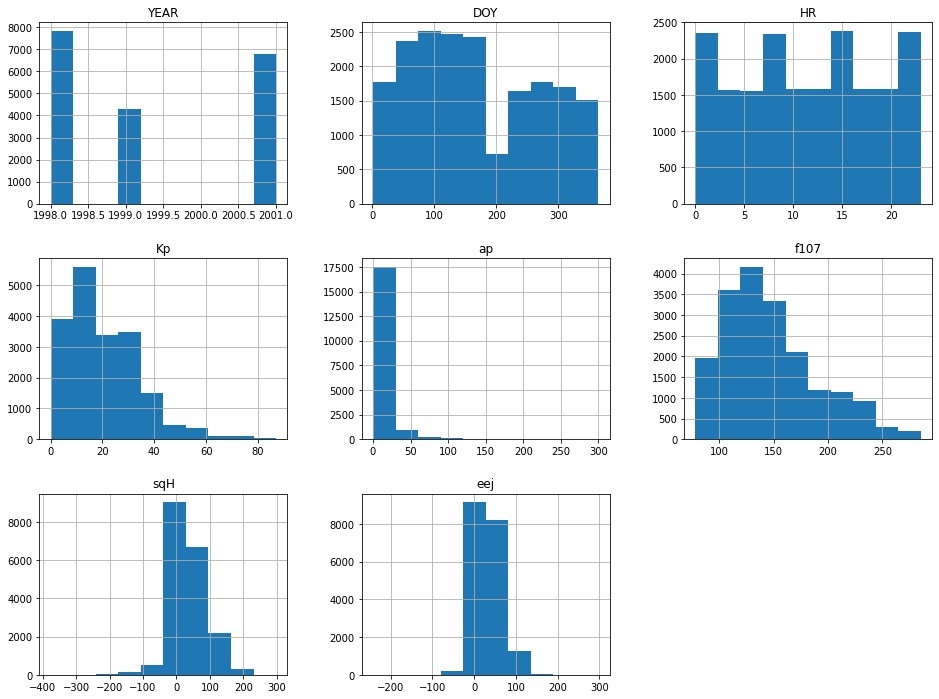

In [22]:
df.hist(['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH', 'eej'], figsize=(16, 12))

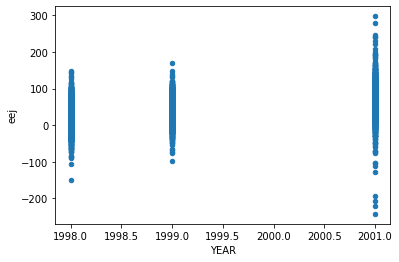

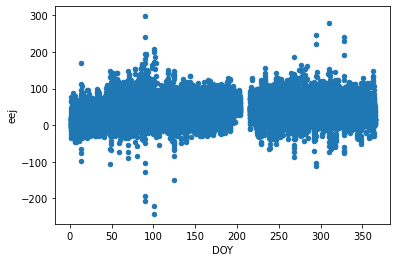

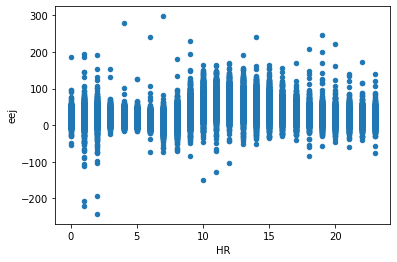

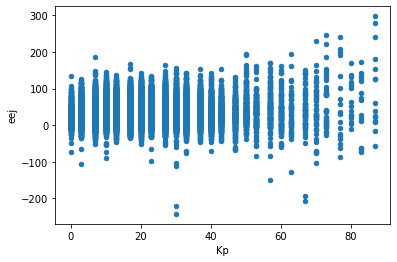

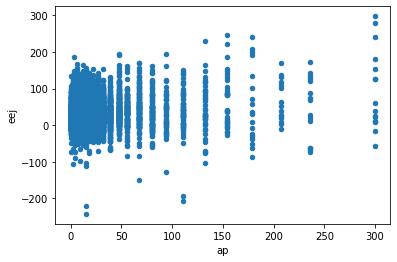

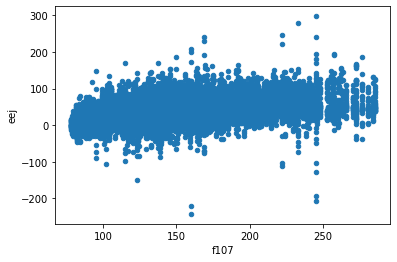

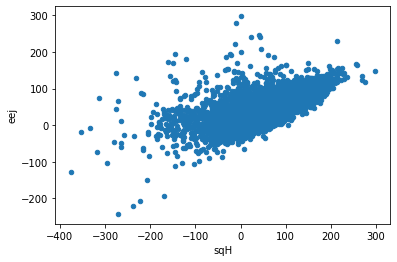

In [23]:
cols = ['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']
for i in cols:
    df.plot.scatter(i, 'eej')

<Figure size 1080x864 with 0 Axes>

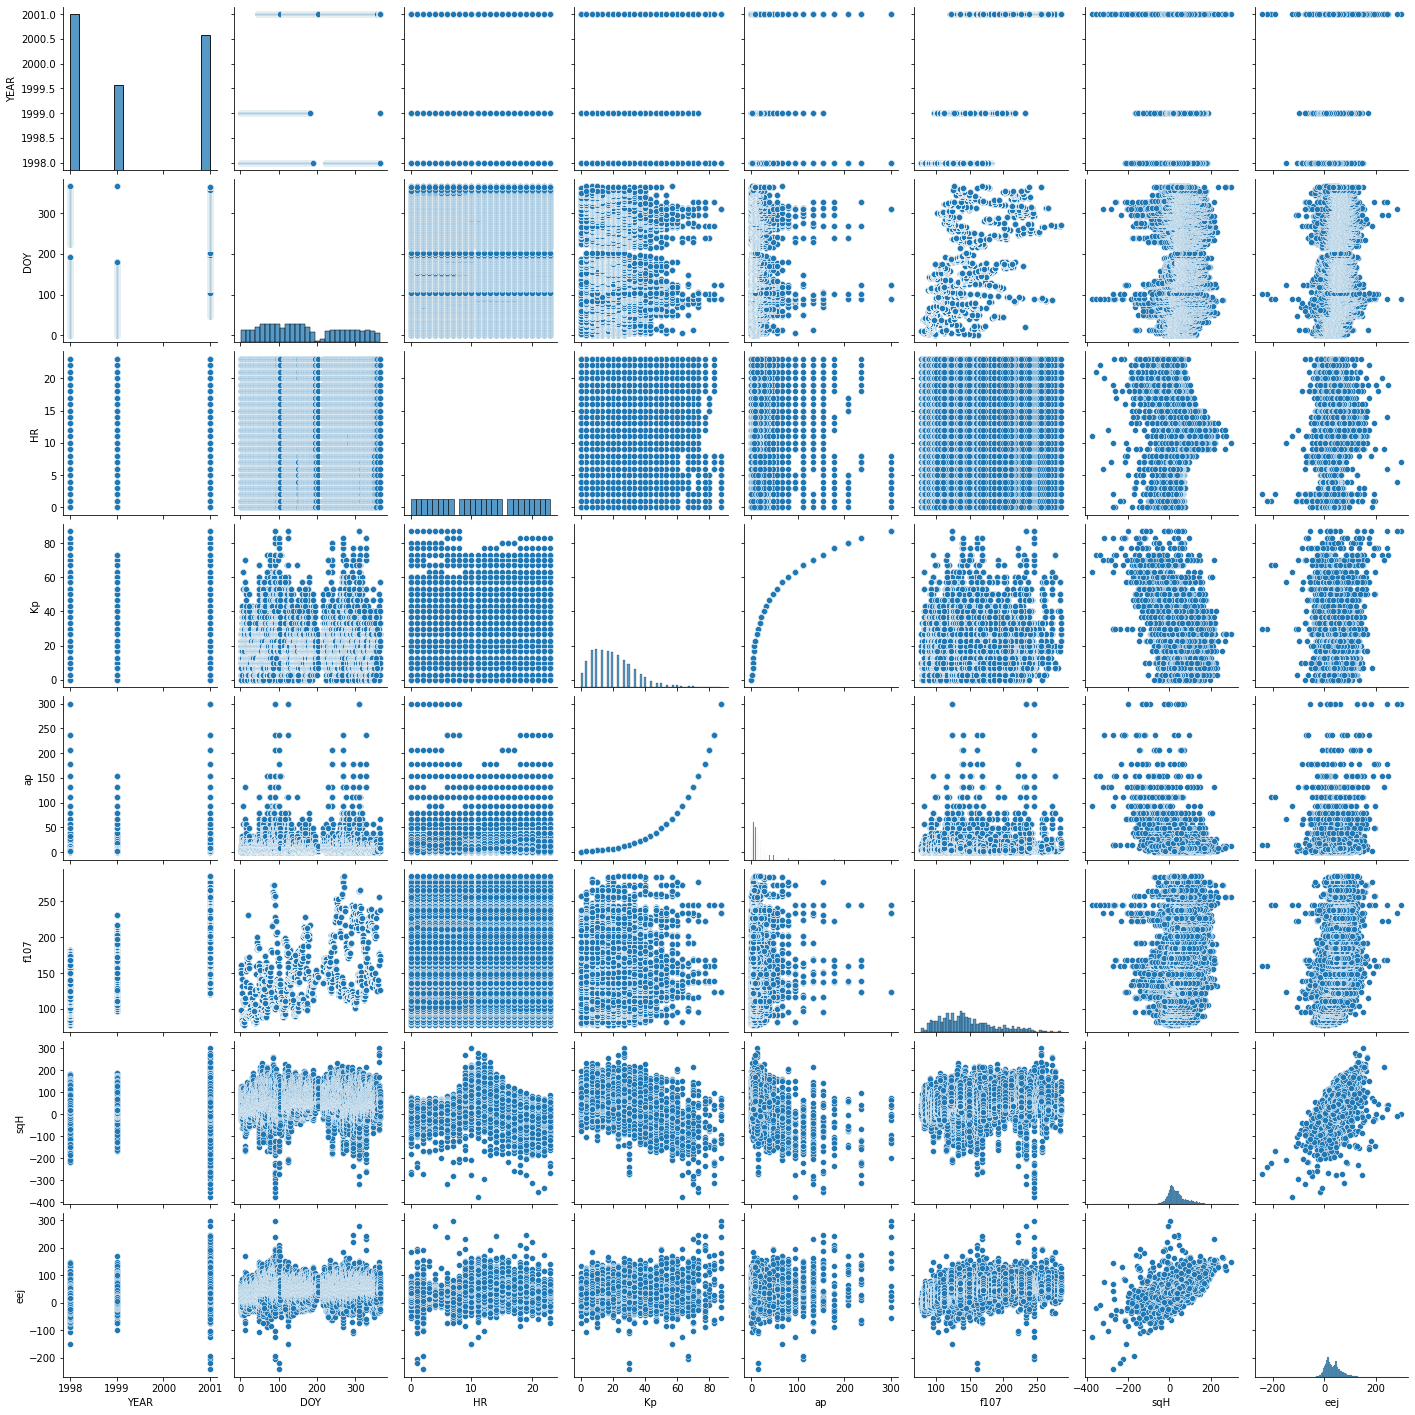

In [24]:
plt.figure(figsize=(15, 12))
sb.pairplot(df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH', 'eej']])

(18910, 7)
(18910,)
R-squared : 0.7049782434272854
Mean Absolute Error : 11.391197481531425
Mean Squared Error : 275.1353543656211
Root Mean Squared Error : 16.58720453740235


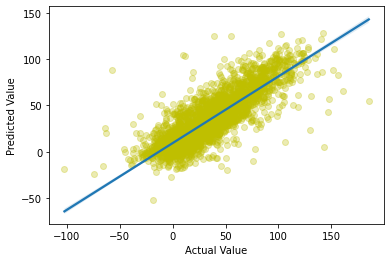

In [26]:
X = df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# calling the linear regression model
linear_regression = LinearRegression() 
linear_regression.fit(X_train, y_train) 

y_pred_lr = linear_regression.predict(X_test)

print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_lr)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_lr)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_lr)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))))

sb.regplot(y_test, y_pred_lr, scatter_kws={'alpha': 0.3, 'color': 'y'})
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

(18910, 7)
(18910,)
R-squared : 0.700123341096726
Mean Absolute Error : 11.179297144196731
Mean Squared Error : 279.66300442318465
Root Mean Squared Error : 16.72312783013945


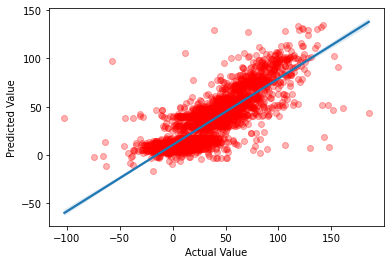

In [28]:
scaler = StandardScaler() 

X = df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)

rf = RandomForestRegressor(max_depth=5, random_state=23)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_rf)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_rf)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_rf)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))))

sb.regplot(y_test, y_pred_rf, scatter_kws={'alpha': 0.3, 'color': 'r'})
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [29]:
cols = ['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']

actual = pd.DataFrame(y_test)
actual.reset_index(drop=True, inplace=True)
actual.rename({'eej': 'Actual_eej'}, axis=1, inplace=True)
test_data = scaler.inverse_transform(X_test)

TestingData = pd.DataFrame(data=test_data, columns=cols)
TestingData = TestingData.merge(actual, left_index=True, right_index=True)

TestingData['Predicted_eej'] = y_pred_rf

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(TestingData.shape)
    display(TestingData.head(100))

(3782, 9)


,YEAR,DOY,HR,Kp,ap,f107,sqH,Actual_eej,Predicted_eej
0,1999.0,136.0,11.0,10.0,4.0,155.6,171.719701,109.582804,99.677551
1,2001.0,311.0,4.0,40.0,27.0,263.9,-80.508807,57.964417,38.658176
2,2001.0,268.0,2.0,7.0,3.0,276.6,-57.092344,-37.394314,38.658176
3,1999.0,133.0,18.0,20.0,7.0,150.5,-75.029747,-38.689467,-1.214009
4,1999.0,91.0,17.0,23.0,9.0,102.9,24.997825,31.650270,17.285286
5,1998.0,230.0,3.0,10.0,4.0,135.8,9.894617,11.789104,12.347454
6,1999.0,8.0,19.0,40.0,27.0,111.7,6.233567,32.442901,14.170779
7,2001.0,261.0,23.0,17.0,6.0,205.7,17.786089,30.099324,48.058176
8,2001.0,302.0,23.0,30.0,15.0,212.8,-9.986394,27.247397,48.058176
9,1999.0,7.0,13.0,27.0,12.0,111.3,100.206530,48.548582,61.065462


In [30]:
# TestingData.to_csv('C:/Users/akint/OneDrive/Documents/Research/output_NN.csv', index=False)

In [31]:
X = df[['sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

xgb = XGBRegressor(n_estimators=150, max_depth=7)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_xgb)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_xgb)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_xgb)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))))

(18910, 1)
(18910,)
R-squared : 0.4959260158344275
Mean Absolute Error : 15.519656754666734
Mean Squared Error : 470.0960901020952
Root Mean Squared Error : 21.681699428368045


(18910, 7)
(18910,)
R-squared : 0.8525329422524481
Mean Absolute Error : 7.550683442904615
Mean Squared Error : 137.52681043585335
Root Mean Squared Error : 11.727182544663204


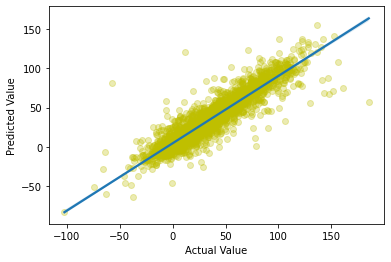

In [32]:
X = df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)

xgb = XGBRegressor(objective ='reg:squarederror', n_estimators=150, max_depth=7)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_xgb)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_xgb)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_xgb)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))))

sb.regplot(y_test, y_pred_xgb, scatter_kws={'alpha':0.3, 'color':'y'})
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [33]:
cols = ['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']

actual = pd.DataFrame(y_test)
actual.reset_index(drop=True, inplace=True)
actual.rename({'eej': 'Actual_eej'}, axis=1, inplace=True)
test_data = scaler.inverse_transform(X_test)

TestingData = pd.DataFrame(data=test_data, columns=cols)
TestingData = TestingData.merge(actual, left_index=True, right_index=True)

TestingData['Predicted_eej'] = y_pred_xgb

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(TestingData.shape)
    display(TestingData.head(100))

(3782, 9)


,YEAR,DOY,HR,Kp,ap,f107,sqH,Actual_eej,Predicted_eej
0,1999.0,136.0,11.0,10.0,4.0,155.6,171.719701,109.582804,96.893585
1,2001.0,311.0,4.0,40.0,27.0,263.9,-80.508807,57.964417,35.271347
2,2001.0,268.0,2.0,7.0,3.0,276.6,-57.092344,-37.394314,-63.425129
3,1999.0,133.0,18.0,20.0,7.0,150.5,-75.029747,-38.689467,-12.234976
4,1999.0,91.0,17.0,23.0,9.0,102.9,24.997825,31.650270,28.015415
5,1998.0,230.0,3.0,10.0,4.0,135.8,9.894617,11.789104,11.710501
6,1999.0,8.0,19.0,40.0,27.0,111.7,6.233567,32.442901,33.939579
7,2001.0,261.0,23.0,17.0,6.0,205.7,17.786089,30.099324,36.066418
8,2001.0,302.0,23.0,30.0,15.0,212.8,-9.986394,27.247397,37.709049
9,1999.0,7.0,13.0,27.0,12.0,111.3,100.206530,48.548582,61.102398


In [34]:
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

def plot_residual_vs_observed(predicted, observed, dep_name, model_name):
    '''
    Plot residual vs observed.
    
    predicted: numpy array, predicted values
    observed: numpy array, observed values
    dep_name: string, dependent variable name
    model_name: string, type of the regression model
    '''
    
    # get residule
    residual = predicted - observed

    # calculate y-axis range based on residual
    upper = np.max(residual)
    lower = np.min(residual)
    y_range = max(abs(upper), abs(lower))*1.5
    
    # calcuate x-axis range based on observed
    x_low = np.min(observed) * 0.8
    x_high = np.max(observed) * 1.2

    # Set up plot area
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(18, 8))

    
    # Plot model residuals
    ax.scatter(observed, residual, alpha = .5)

    # Show zero residual line
    ax.hlines(0, x_low, x_high, color='r', linestyle='--', alpha=0.25)

    # Decorate final plot
    ax.set_xlabel(dep_name, fontsize=14)
    ax.set_ylabel("Residual", fontsize=14)
    ax.set_title(f"Residual vs. Observed: {model_name}", fontsize=18)
    ax.set_ylim(-y_range, y_range)
    sns.despine(ax=ax, trim=True)

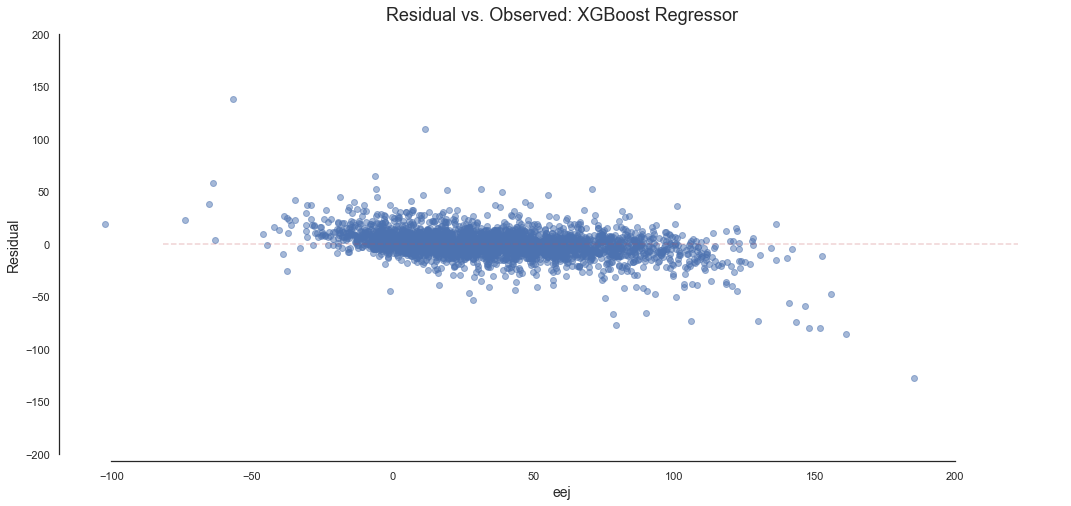

In [35]:
# Residual vs. Observed Plot
plot_residual_vs_observed(y_pred_xgb, y_test, 'eej', 'XGBoost Regressor')

In [36]:
X = df[['sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

nn_mlp = MLPRegressor()
nn_mlp.fit(X_train, y_train)

y_pred_nn = nn_mlp.predict(X_test)

print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_nn)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_nn)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_nn)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn))))

(18910, 1)
(18910,)
R-squared : 0.5411859334276214
Mean Absolute Error : 15.04484966285337
Mean Squared Error : 427.88698793205583
Root Mean Squared Error : 20.685429363009504


(18910, 7)
(18910,)
R-squared : 0.7719675637457346
Mean Absolute Error : 9.689521214858829
Mean Squared Error : 212.66155379360845
Root Mean Squared Error : 14.582919933730983


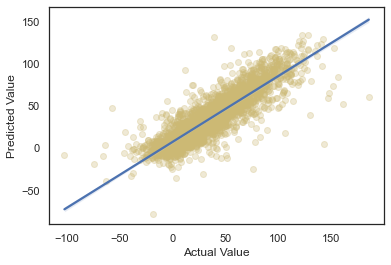

In [37]:
X = df[['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'sqH']]
y = df['eej']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)

nn_mlp = MLPRegressor(hidden_layer_sizes=(30, 15), learning_rate_init=0.01, early_stopping=True, random_state=23)
nn_mlp.fit(X_train, y_train)

y_pred_nn = nn_mlp.predict(X_test)
 
print('R-squared : ' + str(metrics.r2_score(y_test, y_pred_nn)))
print('Mean Absolute Error : ' + str(metrics.mean_absolute_error(y_test, y_pred_nn)))
print('Mean Squared Error : ' + str(metrics.mean_squared_error(y_test, y_pred_nn)))
print('Root Mean Squared Error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn))))

sb.regplot(y_test, y_pred_nn, scatter_kws={'alpha':0.3, 'color':'y'})
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [38]:
cols = ['YEAR', 'DOY', 'HR', 'Kp', 'ap', 'f107', 'H']

actual = pd.DataFrame(y_test)
actual.reset_index(drop=True, inplace=True)
actual.rename({'eej': 'Actual_eej'}, axis=1, inplace=True)
test_data = scaler.inverse_transform(X_test)

TestingData = pd.DataFrame(data=test_data, columns=cols)
TestingData = TestingData.merge(actual, left_index=True, right_index=True)

TestingData['Predicted_eej'] = y_pred_nn

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(TestingData.shape)
    display(TestingData.head(100))

(3782, 9)


,YEAR,DOY,HR,Kp,ap,f107,H,Actual_eej,Predicted_eej
0,1999.0,136.0,11.0,10.0,4.0,155.6,171.719701,109.582804,94.970091
1,2001.0,311.0,4.0,40.0,27.0,263.9,-80.508807,57.964417,19.474034
2,2001.0,268.0,2.0,7.0,3.0,276.6,-57.092344,-37.394314,12.547661
3,1999.0,133.0,18.0,20.0,7.0,150.5,-75.029747,-38.689467,-2.659804
4,1999.0,91.0,17.0,23.0,9.0,102.9,24.997825,31.650270,28.112122
5,1998.0,230.0,3.0,10.0,4.0,135.8,9.894617,11.789104,10.535827
6,1999.0,8.0,19.0,40.0,27.0,111.7,6.233567,32.442901,26.584629
7,2001.0,261.0,23.0,17.0,6.0,205.7,17.786089,30.099324,38.703496
8,2001.0,302.0,23.0,30.0,15.0,212.8,-9.986394,27.247397,31.677551
9,1999.0,7.0,13.0,27.0,12.0,111.3,100.206530,48.548582,72.365583


<Figure size 1152x504 with 0 Axes>

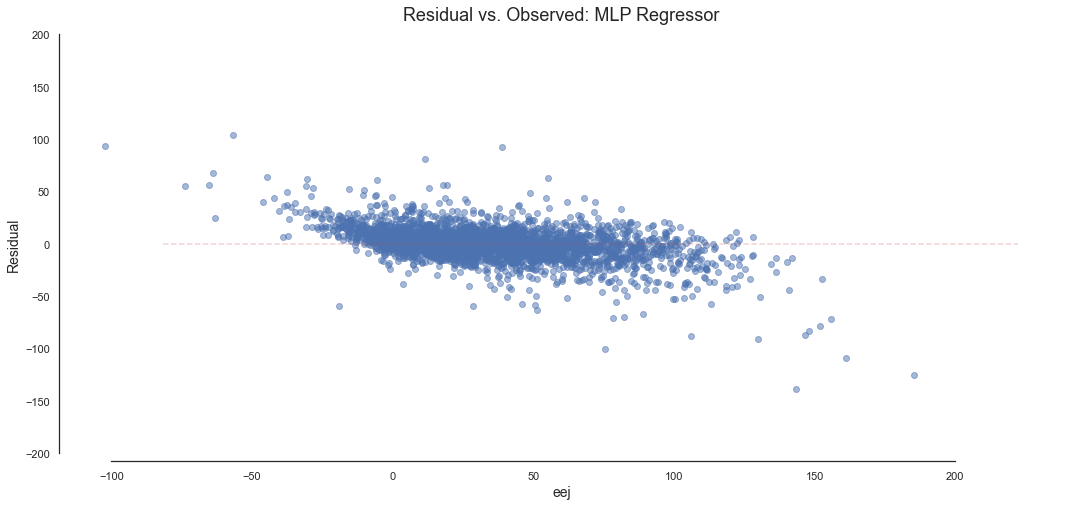

In [39]:
# Residual vs. Observed Plot
plt.figure(figsize=(16, 7))
plot_residual_vs_observed(y_pred_nn, y_test, 'eej', 'MLP Regressor')

### 2. Data Preprocessing

In [ ]:
# def preprocess_data(data):
#   import numpy as np
#   import pandas as pd
  
#   bad_data = data[(data.AE == 9999) | (data.f107 == 999.9) | (data.AU == 99999)]
#   print(bad_data.shape)
#   data = data[(data.AE != 9999) & (data.f107 != 999.9) & (data.AU != 99999)]
#   print(data.shape)
#   display(data)

#   return data

In [ ]:
# def preprocess_hdata(path):
#     import pandas as pd
#     import numpy as np
#     import os
#     import glob

#     # use glob to get all the csv files in the folder
#     # path = 'drive/My Drive/Colab_Work/work_station' # os.getcwd()
#     all_files = glob.glob(os.path.join(path, "*.min"))

#     dfs = []
#     # loop over the list of csv files
#     for file in all_files:
#       # read the csv file
#         df = pd.read_csv(file, delim_whitespace=True, skiprows=26, names=['DATE', 'TIME', 'DOY', 'AAEX', 'AAEY', 'AAEZ', 'AAEF_G'])
#         dfs.append(df)
#     # aliter
#     hdata = pd.concat((pd.read_csv(file, delim_whitespace=True, skiprows=26, names=['DATE', 'TIME', 'DOY', 'AAEX', 'AAEY', 'AAEZ', 'AAEF_G'])\
#                        for file in all_files), axis=0, ignore_index=True)
#     # concatenate files
#     hdata = pd.concat(dfs, axis=0, ignore_index=True)
#     print(hdata.shape)
    
#     hdata['H'] = np.sqrt(hdata['AAEX']**2 + hdata['AAEY']**2)
    
#     hdata[["YEAR", "MONTH", "DAY"]] = hdata["DATE"].str.split("-", expand = True)
    
#     hdata[["HR", "MIN", "SEC"]] = hdata["TIME"].str.split(":", expand = True)
    
#     return hdata

### 3. Modeling

### 4. Model Evaluation